In [3]:
import numpy as np
from matplotlib import pyplot as plt
import bayesmsd
import noctiluca as nl

# Model-free MSD fitting
``bayesmsd`` can fit essentially any shape of MSD to your data, so long as you can give a parametric expression for what you expect the MSD to be (such that we have finitely many parameters to vary). This would usually be based on some modelling assumptions (e.g. a Rouse model) or general physical expectations (e.g. a powerlaw). What if you don't have such a model?

``bayesmsd.lib.SplineFit`` provides a fitting setup for cubic splines. Cubic splines are defined by a set of node points, between which the curve is interpolated with a cubic polynomial. This works quite well for fitting free-form MSDs.

To get started, we need a dataset with non-trivial MSD. We shape this from a few powerlaws, with the exact expression (code below) not being particularly relevant for now. For added realism we introduce a bit of "dirt" into the data by sampling different trajectory lengths and randomly removing 20% of the frames.

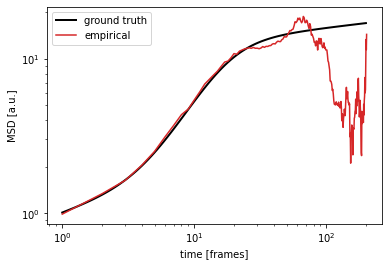

In [88]:
@bayesmsd.deco.MSDfun
def msd_theory(dt):
    return ((dt**0.6 + 0.03*dt**3)**-1 + 0.01*dt**-0.2)**-0.5

def gen_traj(T, p_miss_frame=0.2):
    traj = bayesmsd.gp.generate((msd_theory, 1, 1), T)[0]
    traj.data[:, np.random.rand(len(traj)) < p_miss_frame, :] = np.nan
    return traj

np.random.seed(29439928)
data = nl.TaggedSet((gen_traj(T) for T in np.random.geometric(1/40, size=50) + 10),
                    hasTags=False,
                   )

# Let's look at what we got
dt = np.logspace(0, 2.3, 100)
plt.plot(dt, msd_theory(dt), color='k', linewidth=2, label='ground truth')

msd_measured = nl.analysis.MSD(data)
plt.plot(np.arange(1, len(msd_measured)), msd_measured[1:], color='tab:red', label='empirical')

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('time [frames]')
plt.ylabel('MSD [a.u.]')
plt.show()

So now, given the empirically observed MSD (red line), what can we learn about the data?

Let's fit a few splines to this, with increasing flexibility (i.e. number ``n`` of spline points):

In [89]:
# First fit: n = 2 spline points
fit = bayesmsd.lib.SplineFit(data, ss_order=1, n=2)
results = [fit.run(show_progress=True)]

# Run fits with more spline points
# SplineFit can use a previously run instance (with fewer points)
# as inital condition; this speeds up convergence and ensures consistency
for n in range(3, 7):
    print(f"n = {n}")
    fit = bayesmsd.lib.SplineFit(data, ss_order=1, n=n,
                                 previous_spline_fit_and_result=(fit, results[-1]),
                                )
    results.append(fit.run(show_progress=True))


n = 3



n = 4



n = 5



n = 6


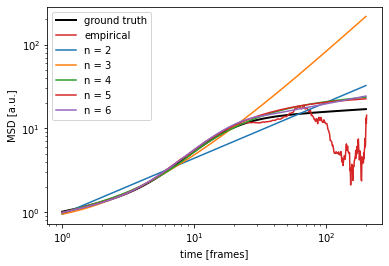

In [98]:
# Plot everything
dt = np.logspace(0, 2.3, 100)
plt.plot(dt, msd_theory(dt), color='k', linewidth=2, label='ground truth')

msd_measured = nl.analysis.MSD(data)
plt.plot(np.arange(1, len(msd_measured)), msd_measured[1:], color='tab:red', label='empirical')

for n, res in enumerate(results, start=2):
    fit = bayesmsd.lib.SplineFit(data, ss_order=1, n=n)
    msd_fitted = fit.MSD(res['params'], dt)
    plt.plot(dt, msd_fitted,
             label=f'n = {n}',
            )

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('time [frames]')
plt.ylabel('MSD [a.u.]')
plt.show()

We can clearly see how the spline starts approximating the true curve as we add more spline points, and converges around ``n = 4``. We can use the Akaike Information Criterion to pick one "best" fit:

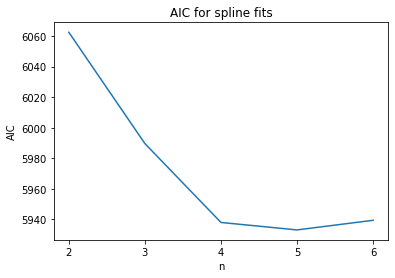

In [100]:
aic = []
for n, res in enumerate(results, start=2):
    fit = bayesmsd.lib.SplineFit(data, ss_order=1, n=n)
    aic.append(-2*(res['logL'] - len(fit.independent_parameters())))
    
n = np.arange(len(aic))+2
plt.plot(n, aic)
plt.xticks(n)
plt.xlabel('n')
plt.ylabel('AIC')
plt.title('AIC for spline fits')
plt.show()

According to this metric, the fit with ``n=5`` points is the best one (lowest AIC). As can be seen in the plot above, qualitatively this reproduces the theoretical MSD quite well. Quantitatively there is a slight mismatch towards the end, which is presumably due to only very little data out there. We will learn in an upcoming tutorial how to check that this is indeed the case, by using the ``Profiler`` class to put error bars on our fitted MSDs.